## Dataset Analysis and Feature Selection

### Install Packages and Modules

In [1]:
%%sh
pip install gffutils # https://pythonhosted.org/pyfaidx/
pip install pyfaidx # https://pythonhosted.org/gffutils/contents.html
pip install biopython

### Import modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import gffutils
import pyfaidx

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.metrics import *

from numpy import array
from numpy import argmax
from sklearn.preprocessing import OneHotEncoder
import re

### Python Analysis Settings

In [28]:
# Notebook specific behavior setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = 10

%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot")

### Load Data
#### The dataset provided by the previous authors needed to be processed through a custom "features extractor" in order to obtain a dataframe readable by SVM. The classes (1;0) have been obtained using a threshold of 70%

In [5]:
data = "siRNA_features.csv"

In [10]:
#I'm creating a first general dataframe common to every strategy in order to clean it and perfor some check, before creating every single df for each strategy
df = pd.read_csv(data)
df

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,C,U,A,A,U,...,46.45,1.5,CUAAUAU,GAUUUAU,0.462
1,A,A,U,A,U,...,46.80,0.6,AAUAUGU,UUUAUAC,0.384
2,G,A,U,U,U,...,53.21,-1.6,GAUUUAU,CUUUCAA,0.514
3,C,A,A,U,U,...,52.19,0.7,CAAUUCC,UUUAUCU,0.364
4,C,A,G,A,C,...,52.69,2.9,CAGACCA,AUAAGAA,0.522
...,...,...,...,...,...,...,...,...,...,...,...
2423,A,A,A,A,C,...,66.66,-1.5,AAAACCC,AAAGUAG,0.894
2424,G,A,U,G,A,...,64.48,-2.4,GAUGAUC,GAACUAC,0.723
2425,A,U,C,A,G,...,67.66,-3.3,AUCAGAA,UACUCGG,0.918
2426,G,A,A,G,C,...,67.90,0.3,GAAGCUG,CGGUUGA,0.620


### Check for classes distribution

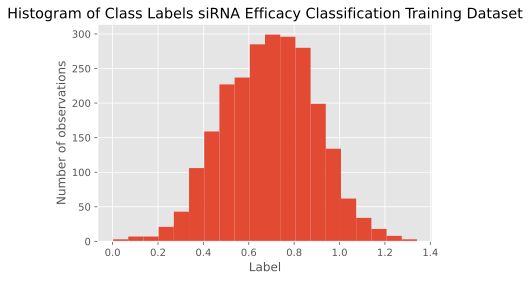

In [11]:
#Create an histogram for the original dataset to check scores distribution
df["Label"].hist(bins=20);
#Add a title and axis labels
plt.title("Histogram of Class Labels siRNA Efficacy Classification Training Dataset");
plt.xlabel("Label");
plt.ylabel("Number of observations");

### General checks before encoding

In [12]:
# Check for Not Null elements in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2428 entries, 0 to 2427
Columns: 125 entries, P1 to Label
dtypes: float64(102), object(23)
memory usage: 2.3+ MB


In [13]:
# Check for Global_ΔG values since it was the column with problems
df["Global_ΔG"].value_counts()

-1.0     63
-0.5     53
 0.3     51
-0.3     45
-2.3     42
         ..
-13.6     1
-11.4     1
-11.6     1
-16.3     1
-9.1      1
Name: Global_ΔG, Length: 164, dtype: int64

In [14]:
#I checked and from row 210 there are some rows with 1600 in the ΔG column, that must be deleted since it's an error
#remove rows using the drop() function
df.drop(df.index[df['Global_ΔG'] > 100.0], inplace=True)
# display the dataframe
df

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,C,U,A,A,U,...,46.45,1.5,CUAAUAU,GAUUUAU,0.462
1,A,A,U,A,U,...,46.80,0.6,AAUAUGU,UUUAUAC,0.384
2,G,A,U,U,U,...,53.21,-1.6,GAUUUAU,CUUUCAA,0.514
3,C,A,A,U,U,...,52.19,0.7,CAAUUCC,UUUAUCU,0.364
4,C,A,G,A,C,...,52.69,2.9,CAGACCA,AUAAGAA,0.522
...,...,...,...,...,...,...,...,...,...,...,...
2423,A,A,A,A,C,...,66.66,-1.5,AAAACCC,AAAGUAG,0.894
2424,G,A,U,G,A,...,64.48,-2.4,GAUGAUC,GAACUAC,0.723
2425,A,U,C,A,G,...,67.66,-3.3,AUCAGAA,UACUCGG,0.918
2426,G,A,A,G,C,...,67.90,0.3,GAAGCUG,CGGUUGA,0.620


In [10]:
#df.drop(df.index[df['Global_ΔG'] == 'inf'], inplace=True)
#df

In [11]:
#outputfile='/Users/christian/Desktop/siRNA ML/siRNA_features_filtered.csv'
#df.to_csv(outputfile,index=False)

In [12]:
#Rename columns (optional)
#df.columns = ["Patient_ID", "Response", "PR_Seq", "RT_Seq", "VL_T0", "CD4_T0"]

In [13]:
#Move the outcome (Response) column at the last column position of the dataset (optional)
#df = df[["Patient_ID", "PR_Seq", "RT_Seq", "VL_T0", "CD4_T0","Response"]]

In [15]:
#Columns check
df.head()

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,C,U,A,A,U,...,46.45,1.5,CUAAUAU,GAUUUAU,0.462
1,A,A,U,A,U,...,46.80,0.6,AAUAUGU,UUUAUAC,0.384
2,G,A,U,U,U,...,53.21,-1.6,GAUUUAU,CUUUCAA,0.514
3,C,A,A,U,U,...,52.19,0.7,CAAUUCC,UUUAUCU,0.364
4,C,A,G,A,C,...,52.69,2.9,CAGACCA,AUAAGAA,0.522


In [16]:
#Check for NAs
pd.isna(df)

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,False,False,False,False,False,...,False,False,False,False,False
1,False,False,False,False,False,...,False,False,False,False,False
2,False,False,False,False,False,...,False,False,False,False,False
3,False,False,False,False,False,...,False,False,False,False,False
4,False,False,False,False,False,...,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2423,False,False,False,False,False,...,False,False,False,False,False
2424,False,False,False,False,False,...,False,False,False,False,False
2425,False,False,False,False,False,...,False,False,False,False,False
2426,False,False,False,False,False,...,False,False,False,False,False


In [17]:
#If there are some NAs, those rows need to be deleted
df = df.dropna()
df

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,C,U,A,A,U,...,46.45,1.5,CUAAUAU,GAUUUAU,0.462
1,A,A,U,A,U,...,46.80,0.6,AAUAUGU,UUUAUAC,0.384
2,G,A,U,U,U,...,53.21,-1.6,GAUUUAU,CUUUCAA,0.514
3,C,A,A,U,U,...,52.19,0.7,CAAUUCC,UUUAUCU,0.364
4,C,A,G,A,C,...,52.69,2.9,CAGACCA,AUAAGAA,0.522
...,...,...,...,...,...,...,...,...,...,...,...
2423,A,A,A,A,C,...,66.66,-1.5,AAAACCC,AAAGUAG,0.894
2424,G,A,U,G,A,...,64.48,-2.4,GAUGAUC,GAACUAC,0.723
2425,A,U,C,A,G,...,67.66,-3.3,AUCAGAA,UACUCGG,0.918
2426,G,A,A,G,C,...,67.90,0.3,GAAGCUG,CGGUUGA,0.620


### Now that NaN rows have been excluded from the dataset, it is possible to proceed witht the Encoding preprocessing step in order to transform nucleotide and amino acid sequences in dummies

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dfLE = df.copy()
dfLE
for col in df.columns:
    print(col)

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,C,U,A,A,U,...,46.45,1.5,CUAAUAU,GAUUUAU,0.462
1,A,A,U,A,U,...,46.80,0.6,AAUAUGU,UUUAUAC,0.384
2,G,A,U,U,U,...,53.21,-1.6,GAUUUAU,CUUUCAA,0.514
3,C,A,A,U,U,...,52.19,0.7,CAAUUCC,UUUAUCU,0.364
4,C,A,G,A,C,...,52.69,2.9,CAGACCA,AUAAGAA,0.522
...,...,...,...,...,...,...,...,...,...,...,...
2423,A,A,A,A,C,...,66.66,-1.5,AAAACCC,AAAGUAG,0.894
2424,G,A,U,G,A,...,64.48,-2.4,GAUGAUC,GAACUAC,0.723
2425,A,U,C,A,G,...,67.66,-3.3,AUCAGAA,UACUCGG,0.918
2426,G,A,A,G,C,...,67.90,0.3,GAAGCUG,CGGUUGA,0.620


P1
P2
P3
P4
P5
P6
P7
P8
P9
P10
P11
P12
P13
P14
P15
P16
P17
P18
P19
P20
P21
GC_Content
GC_1
GC_2
GC_3
GC_4
GC_5
GC_6
GC_7
GC_8
GC_9
GC_10
GC_11
GC_12
GC_13
GC_14
GC_15
GC_16
AA%
AC%
AG%
AU%
CA%
CC%
CG%
CU%
GG%
GA%
GC%
GU%
UA%
UC%
UG%
UU%
AAA%
AAC%
AAU%
AAG%
ACA%
ACC%
ACU%
ACG%
AUA%
AUC%
AUU%
AUG%
AGA%
AGC%
AGU%
AGG%
GGA%
GGC%
GGU%
GGG%
GCA%
GCC%
GCU%
GCG%
GUA%
GUC%
GUU%
GAG%
GAA%
GAC%
GAU%
GUG%
CAA%
CAC%
CAU%
CAG%
CCA%
CCC%
CCU%
CCG%
CGA%
CGC%
CGU%
CGG%
CUA%
CUC%
CUU%
CUG%
UAA%
UAC%
UAU%
UAG%
UCA%
UCC%
UCU%
UCG%
UGA%
UGC%
UGU%
UGG%
UUA%
UUC%
UUU%
UUG%
five_prime_GC
five_prime_AU
Global_Tm
Global_ΔG
five_prime_seq
three_prime_seq
Label


In [19]:
#Label Encoding on specific features (columns)
dfLE['P1'] = le.fit_transform(df['P1'].astype(str))
dfLE['P2'] = le.fit_transform(df['P2'].astype(str))
dfLE['P3'] = le.fit_transform(df['P3'].astype(str))
dfLE['P4'] = le.fit_transform(df['P4'].astype(str))
dfLE['P5'] = le.fit_transform(df['P5'].astype(str))
dfLE['P6'] = le.fit_transform(df['P6'].astype(str))
dfLE['P7'] = le.fit_transform(df['P7'].astype(str))
dfLE['P8'] = le.fit_transform(df['P8'].astype(str))
dfLE['P9'] = le.fit_transform(df['P9'].astype(str))
dfLE['P10'] = le.fit_transform(df['P10'].astype(str))
dfLE['P11'] = le.fit_transform(df['P11'].astype(str))
dfLE['P12'] = le.fit_transform(df['P12'].astype(str))
dfLE['P13'] = le.fit_transform(df['P13'].astype(str))
dfLE['P14'] = le.fit_transform(df['P14'].astype(str))
dfLE['P15'] = le.fit_transform(df['P15'].astype(str))
dfLE['P16'] = le.fit_transform(df['P16'].astype(str))
dfLE['P17'] = le.fit_transform(df['P17'].astype(str))
dfLE['P18'] = le.fit_transform(df['P18'].astype(str))
dfLE['P19'] = le.fit_transform(df['P19'].astype(str))
dfLE['P20'] = le.fit_transform(df['P20'].astype(str))
dfLE['P21'] = le.fit_transform(df['P21'].astype(str))

dfLE['five_prime_seq'] = le.fit_transform(df['five_prime_seq'].astype(str))
dfLE['three_prime_seq'] = le.fit_transform(df['three_prime_seq'].astype(str))
df
dfLE

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,C,U,A,A,U,...,46.45,1.5,CUAAUAU,GAUUUAU,0.462
1,A,A,U,A,U,...,46.80,0.6,AAUAUGU,UUUAUAC,0.384
2,G,A,U,U,U,...,53.21,-1.6,GAUUUAU,CUUUCAA,0.514
3,C,A,A,U,U,...,52.19,0.7,CAAUUCC,UUUAUCU,0.364
4,C,A,G,A,C,...,52.69,2.9,CAGACCA,AUAAGAA,0.522
...,...,...,...,...,...,...,...,...,...,...,...
2423,A,A,A,A,C,...,66.66,-1.5,AAAACCC,AAAGUAG,0.894
2424,G,A,U,G,A,...,64.48,-2.4,GAUGAUC,GAACUAC,0.723
2425,A,U,C,A,G,...,67.66,-3.3,AUCAGAA,UACUCGG,0.918
2426,G,A,A,G,C,...,67.90,0.3,GAAGCUG,CGGUUGA,0.620


,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,1,3,0,0,3,...,46.45,1.5,842,1197,0.462
1,0,0,3,0,3,...,46.80,0.6,87,2132,0.384
2,2,0,3,3,3,...,53.21,-1.6,1125,1051,0.514
3,1,0,0,3,3,...,52.19,0.7,496,2133,0.364
4,1,0,2,0,1,...,52.69,2.9,542,388,0.522
...,...,...,...,...,...,...,...,...,...,...,...
2423,0,0,0,0,1,...,66.66,-1.5,1,20,0.894
2424,2,0,3,2,0,...,64.48,-2.4,1110,1072,0.723
2425,0,3,1,0,2,...,67.66,-3.3,358,1638,0.918
2426,2,0,0,2,1,...,67.90,0.3,1010,876,0.620


In [20]:
#Let's export the Label Encoded dataset on which we are going to perform features analysis and selection
outputfile='/Users/christian/Desktop/siRNA ML/siRNA_Label_Encoded_features.csv'
dfLE.to_csv(outputfile,index=False)

array([[<AxesSubplot:title={'center':'P1'}>,
        <AxesSubplot:title={'center':'P2'}>,
        <AxesSubplot:title={'center':'P3'}>,
        <AxesSubplot:title={'center':'P4'}>,
        <AxesSubplot:title={'center':'P5'}>,
        <AxesSubplot:title={'center':'P6'}>,
        <AxesSubplot:title={'center':'P7'}>,
        <AxesSubplot:title={'center':'P8'}>,
        <AxesSubplot:title={'center':'P9'}>,
        <AxesSubplot:title={'center':'P10'}>,
        <AxesSubplot:title={'center':'P11'}>],
       [<AxesSubplot:title={'center':'P12'}>,
        <AxesSubplot:title={'center':'P13'}>,
        <AxesSubplot:title={'center':'P14'}>,
        <AxesSubplot:title={'center':'P15'}>,
        <AxesSubplot:title={'center':'P16'}>,
        <AxesSubplot:title={'center':'P17'}>,
        <AxesSubplot:title={'center':'P18'}>,
        <AxesSubplot:title={'center':'P19'}>,
        <AxesSubplot:title={'center':'P20'}>,
        <AxesSubplot:title={'center':'P21'}>,
        <AxesSubplot:title={'center':'GC_C

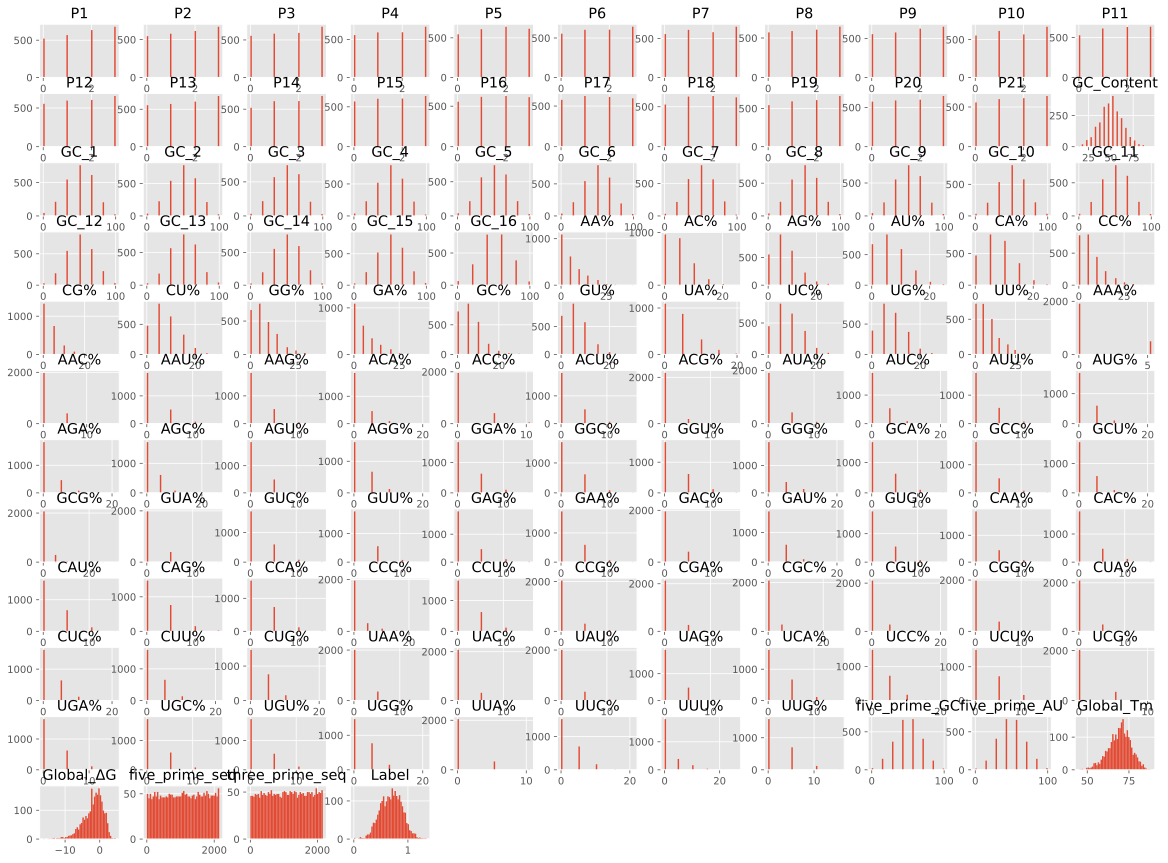

In [21]:
#Check for features distribution. This is a first step for understand which features are importand and which are not
%matplotlib inline
import matplotlib.pyplot as plt
dfLE.hist(bins=50, figsize=(20,15))
plt.show()

### Look at the correlation between certain features and the silencing score that has not been thresholded yet

In [ ]:
#Let's look at the Pearson coefficient between the score (Label) and each feature, where 0 is no correlation, 1 is positive correlation and -1 is negative correlation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

corr_matrix = dfLE.corr()
corr_matrix["Label"].sort_values(ascending=False)

### Now we can select the most correlated features and check their correlation with a scatter matrix

In [ ]:
#Let's produce a scatter matrix of certain feature in relation to the silencing score from Huesken et al. (2005)
from pandas.plotting import scatter_matrix

attributes = ["GC_Content", "Global_Tm", "Global_ΔG", "five_prime_GC", "GC_1", "GC_2", "UU%", "UA%", "Label"]
scatter_matrix(dfLE[attributes], figsize=(12, 8))